In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from himalaya.ridge import RidgeCV
import numpy as np
from pathlib import Path
from AOTaccess.stimulus_info_access import StimuliInfoAccess
from AOTaccess.glmsingle_access import GLMSingleAccess

from himalaya.backend import set_backend

backend = set_backend("numpy", on_error="warn")

from AOTanalysis.bandedRR.utils import (
    reshape_from_flatten_masked_to_wholebrain,
)
from AOTanalysis.voxelsemantic.corpus_construct import construct_AOT_corpus
import joblib
import pickle
from pprint import pprint

import matplotlib.pyplot as plt
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from nibabel import Nifti1Image
import cortex
import nibabel as nib
import os
opj = os.path.join

from matplotlib.colors import Normalize
def Vertex2D_fix(data1, data2, subject, cmap, vmin, vmax, vmin2, vmax2, roi_borders=None):
    #this provides a nice workaround for pycortex opacity issues, at the cost of interactivity    
    # Get curvature
    curv = cortex.db.get_surfinfo(subject)
    # Adjust curvature contrast / color
    curv.data = curv.data * .75 +0.1
    curv = cortex.Vertex(curv.data, subject, vmin=-1,vmax=1,cmap='gray')
    norm2 = Normalize(vmin2, vmax2)   
    vx = cortex.Vertex(data1, subject, cmap=cmap, vmin=vmin, vmax=vmax)
    # Map to RGB
    vx_rgb = np.vstack([vx.raw.red.data, vx.raw.green.data, vx.raw.blue.data])
    curv_rgb = np.vstack([curv.raw.red.data, curv.raw.green.data, curv.raw.blue.data])
    # Alpha mask
    alpha = np.clip(norm2(data2), 0, 1)
    display_data = (curv_rgb * (1-alpha)) + vx_rgb * alpha
    display_data /= 255
    if roi_borders is not None:
        display_data[:,roi_borders.astype('bool')] = 0
    
    # Create vertex RGB object out of R, G, B channels
    return cortex.VertexRGB(*display_data, subject) 


backend = set_backend("numpy", on_error="warn")

In [3]:
sub = 1
#model_path = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_session_testinside2/model_sub{sub}_feature_motion32_trainses_1_Xcentered_True_Yzscore_True_Xstd_True_testinside.joblib"
model_path = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_multiple_session_based/model_sub{sub}_feature_motion_trainses_1_2_3.joblib"
#model_path = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_multiple_session_based/model_sub{sub}_feature_motion_trainses_1.joblib"
model = joblib.load(model_path)
cx_sub = f'sub-{sub:03d}'
deriv_dir = '/tank/shared/2024/visual/AOT/derivatives/'
param_path_dir = opj(deriv_dir, "prf", cx_sub)
fs_dir = opj(deriv_dir, "freesurfer")

/tank/marcus/miniconda3/envs/aot_003/lib/python3.13/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tank/marcus/miniconda3/envs/aot_003/lib/python3.13/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.3.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [12]:
primal_coef = model[-1].get_primal_coef()
primal_coef = backend.to_numpy(primal_coef)
print("(n_features, n_voxels) =", primal_coef.shape)
primal_coef = primal_coef.numpy()
# max_index = np.argmax(primal_coef, axis=0)
# print("max_index.shape =", max_index.shape)

(n_features, n_voxels) = torch.Size([11845, 336275])


In [32]:
# Load the R2 scores for masking
R2_file = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_multiple_session_based/R2_score_single_sub{sub}_motion_train_1_2_3_test_4.nii.gz"
R2 = nib.load(R2_file)
R2_data = R2.get_fdata()
print("R2_data shape:", R2_data.shape)
R2_data = np.transpose(R2_data, (2, 1, 0))
print("Transposed R2_data shape:", R2_data.shape)

R2_data shape: (81, 95, 101)
Transposed R2_data shape: (101, 95, 81)


In [33]:
ses=1
glmaccess = GLMSingleAccess()
mask = glmaccess.read_R2_mask(sub, ses=ses)
shape = glmaccess.read_shape(sub, ses=ses)
voxel_num = np.prod(shape)
flatten_mask = mask.flatten()
data_reshape = np.zeros(voxel_num)
r2_flat = R2_data.flatten()[flatten_mask]
r2_flat

array([0., 0., 0., ..., 0., 0., 0.], shape=(336275,))

In [24]:
ns.vhsize

(160, 240)

In [45]:

from AOTanalysis.voxelmotion.filter_info import *
ns = NishiStim()
ds = 10
f_pre = ''
file = f'./{f_pre}ns_space{ds}'
if not os.path.exists(file):
    ns._stim_make_space(grid_size=(5,5), downsample=ds)
    with open(file, 'wb') as f:
        pickle.dump(ns.stim_space, file=f)
else:
    with open(file, 'rb') as f:
        ns.stim_space = pickle.load(f)

file = f'./{f_pre}ns_gray{ds}'
if not os.path.exists(file):
    ns._stim_make_gray(downsample=ds)
    with open(file, 'wb') as f:
        pickle.dump(ns.stim_gray, file=f)
else:
    with open(file, 'rb') as f:
        ns.stim_gray = pickle.load(f)

# ds = 60
file = f'./{f_pre}ns_tfsf{ds}b'
if not os.path.exists(file):
    ns._stim_make_tfsf(downsample=ds, dir_list=np.linspace(0,360,5)[:-1])
    with open(file, 'wb') as f:
        pickle.dump(ns.stim_tfsf, file=f)
else:
    with open(file, 'rb') as f:
        ns.stim_tfsf = pickle.load(f)

ns.stim_space['stim_x'] = ns.stim_space['filt_x']
ns.stim_space['stim_y'] = ns.stim_space['filt_y']


/tank/marcus/programs/AOT_analysis_mdag/AOTanalysis/voxelmotion/filter_info.py:73: RuntimeWarning: divide by zero encountered in divide
  vel = data['TF'] / data['SF']
/tank/marcus/programs/AOT_analysis_mdag/AOTanalysis/voxelmotion/filter_info.py:73: RuntimeWarning: invalid value encountered in divide
  vel = data['TF'] / data['SF']


array([10859, 10825,  9286, ..., 73814, 22823, 38530], shape=(336275,))

In [35]:
r2_flat[10859]

np.float64(0.3595852851867676)

(6, 3, 1)
(6, 3, 1)
(6, 3, 1)
(6, 3, 1)
(6, 3, 1)


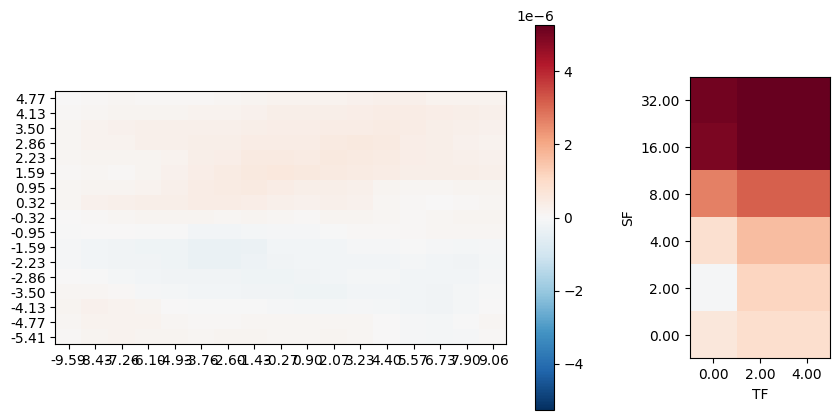

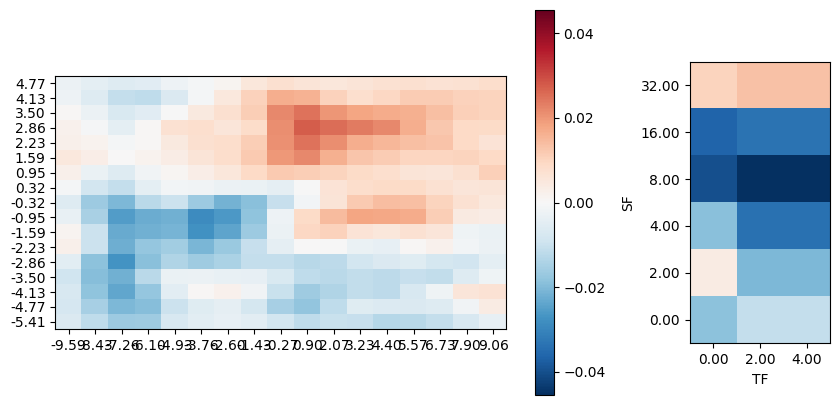

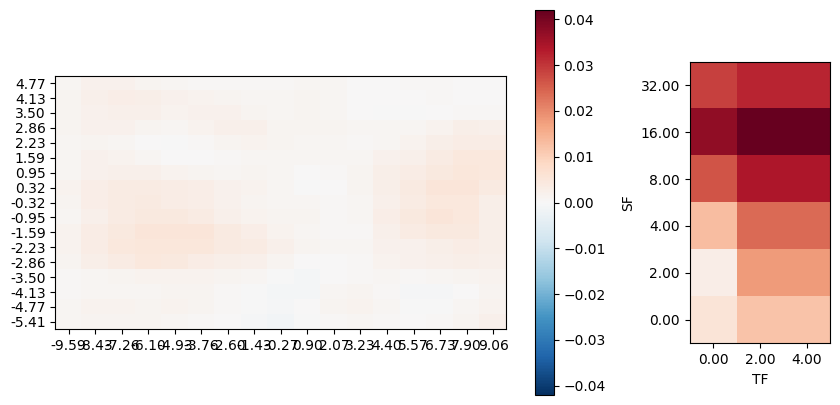

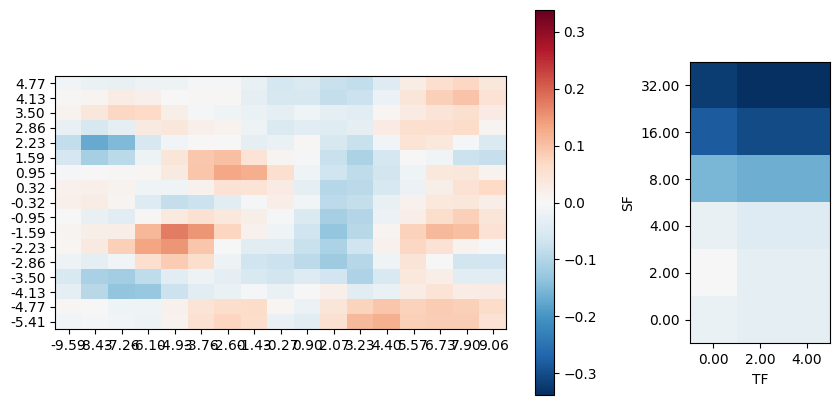

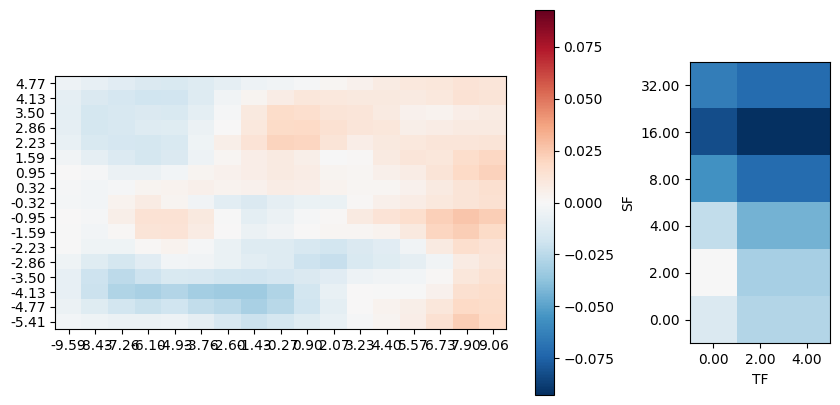

In [39]:
a =  np.argsort(r2_flat)[-1::-1]
for i in a[:5]:
    ns.nish_stim_plot(primal_coef[:,i])

In [177]:
space_mat = ns._pref_space(primal_coef)

In [49]:
beep = np.argmax(space_mat, axis=0)

In [178]:
# Get indices of maximum value for each slice
max_xy = [np.argmax(space_mat[:,:,i].flatten()) for i in range(space_mat.shape[-1])] 
# Now the 
# max_xy will contain the (x,y) coordinates for the maximum value in each slice
# max_xy[:, 0] contains all x coordinates 
# max_xy[:, 1] contains all y coordinates

In [179]:
max_x = [ns.stim_space['filt_x'][i] for i in max_xy]
max_y = [ns.stim_space['filt_y'][i] for i in max_xy]

In [180]:
ecc,pol = ns._cart2pol(max_x, max_y)

In [72]:
wm = ns.filter_weighted_mean(primal_coef)

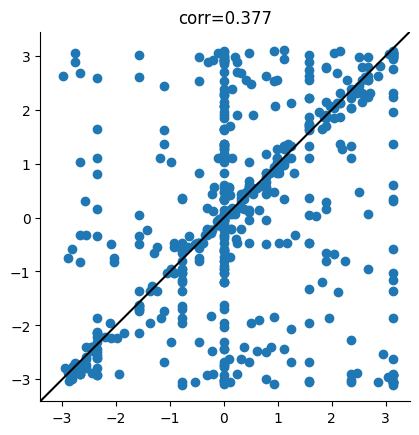

In [191]:
from dpu_mini.plot_functions import *
r2_mask = r2_flat>0.05
dag_scatter(
    wmax['pol'][r2_mask],
    np.array(pol)[r2_mask],
    do_id_line =True, do_corr=True,
)

In [86]:
dir_pref = ns._pref_dir(primal_coef)

(4, 336275)


In [90]:
dir_pref_id = np.argmax(dir_pref, axis=0)
dir_pref_1 = [ns.stim_tfsf['dir'][i] for i in dir_pref_id]

(-10.0, 10.0)

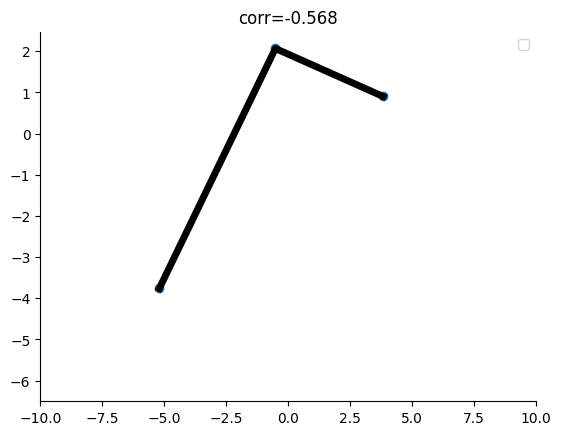

In [128]:
r2_mask = r2_flat>0.3
dag_scatter(
    wm['x'][r2_mask], 
    np.array(max_x)[r2_mask],
    # np.array(dir_pref_1)[r2_mask],
    do_corr=True,
    do_line=True,
    bins=np.linspace(-10,10,10) 
)
plt.gca().set_xlim(-10,10)

In [98]:
dir_pref_1

[np.float64(0.0),
 np.float64(0.0),
 np.float64(90.0),
 np.float64(180.0),
 np.float64(0.0),
 np.float64(90.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(90.0),
 np.float64(90.0),
 np.float64(180.0),
 np.float64(0.0),
 np.float64(90.0),
 np.float64(180.0),
 np.float64(180.0),
 np.float64(0.0),
 np.float64(180.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(90.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(180.0),
 np.float64(0.0),
 np.float64(180.0),
 np.float64(90.0),
 np.float64(180.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(90.0),
 np.float64(0.0),
 np.float64(180.0),
 np.float64(180.0),
 np.float64(0.0),
 np.float64(90.0),
 np.float64(0.0),
 np.float64(180.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(180.0),
 np.float64(180.0),
 np.float64(180.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(90.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.floa

In [83]:
ns.stim_tfsf['dir']

[np.float64(0.0),
 np.float64(0.0),
 np.float64(90.0),
 np.float64(180.0),
 np.float64(270.0),
 np.float64(0.0),
 np.float64(90.0),
 np.float64(180.0),
 np.float64(270.0),
 np.float64(0.0),
 np.float64(90.0),
 np.float64(180.0),
 np.float64(270.0),
 np.float64(0.0),
 np.float64(90.0),
 np.float64(180.0),
 np.float64(270.0),
 np.float64(0.0),
 np.float64(90.0),
 np.float64(180.0),
 np.float64(270.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(90.0),
 np.float64(180.0),
 np.float64(270.0),
 np.float64(0.0),
 np.float64(90.0),
 np.float64(180.0),
 np.float64(270.0),
 np.float64(0.0),
 np.float64(90.0),
 np.float64(180.0),
 np.float64(270.0),
 np.float64(0.0),
 np.float64(90.0),
 np.float64(180.0),
 np.float64(270.0),
 np.float64(0.0),
 np.float64(90.0),
 np.float64(180.0),
 np.float64(270.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(90.0),
 np.float64(180.0),
 np.float64(270.0),
 np.float64(0.0),
 np.float64(90.0),
 np.float64(180.0),
 np.float64(270.0),
 np.float64(0.0),
 np.

(6, 3, 1)
[np.float64(0.9011675328625023), np.float64(-0.9541773877367666)]


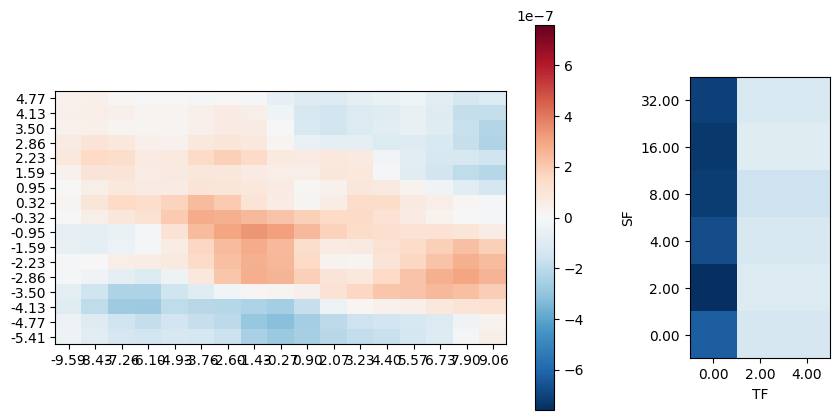

In [129]:
i=22
ns.nish_stim_plot(primal_coef[:,i])
print([max_x[i], max_y[i]])

In [107]:
ns.stim_space['filt_y']

[np.float64(-3.816709550947068),
 np.float64(0.0),
 np.float64(3.816709550947068),
 np.float64(-3.816709550947068),
 np.float64(0.0),
 np.float64(3.816709550947068),
 np.float64(-3.816709550947068),
 np.float64(0.0),
 np.float64(3.816709550947068)]

In [72]:
a = ns._pref_space(primal_coef[:,:2])

NEED TO CHECK IF RESHAPE IS CORRECT!!


In [101]:
a = ns._pref_tfsf(primal_coef) #[:,:30000])

(63, 11845)
(6, 3, 336275)
NEED TO CHECK IF RESHAPE IS CORRECT!!


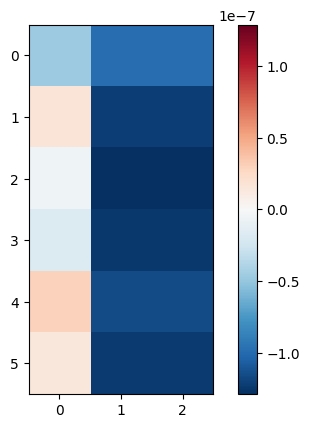

In [104]:
i = 10
plt.imshow(
    a[:,:,i], cmap='RdBu_r', 
    vmin=-np.max(np.abs(a[:,:,i])),
    vmax=np.max(np.abs(a[:,:,i])),
)
plt.colorbar()

In [83]:
primal_coef.shape

(11845, 336275)

In [76]:
ns.stim_tfsf['filt_resp'].shape

(24, 11845)

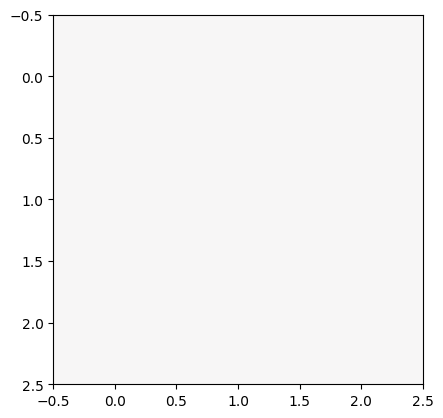

In [68]:
plt.imshow(a[:,:,60], cmap='RdBu_r', vmin=-.1, vmax=.1)

In [269]:
ns._stim_make_gray(downsample=60)

Downsampled vhsize = (18, 32)


project_stimulus:   0%|          | 0/11845 [00:00<?, ?it/s]

project_stimulus: 100%|██████████| 11845/11845 [00:03<00:00, 3484.01it/s]


In [282]:
a = ns._stim_make_tfsf(downsample=60)

Downsampled vhsize = (18, 32)
0, 0, 0


project_stimulus:   9%|▊         | 1019/11845 [00:00<00:03, 3425.93it/s]

project_stimulus: 100%|██████████| 11845/11845 [00:03<00:00, 3431.89it/s]


AttributeError: 'NishiStim' object has no attribute 'stistim_tfsfm_gray'

In [216]:
plt.imshow(a[24,:,:], vmin=0, vmax=100)

IndexError: index 24 is out of bounds for axis 0 with size 24

In [188]:
ns.stim_space['filt_resp_avg'][0].shape

(11845,)

In [193]:
ns._stim_make_gray(downsample=40)

Downsampled vhsize = (27, 48)


project_stimulus: 100%|██████████| 11845/11845 [00:04<00:00, 2838.91it/s]


In [194]:
ns.stim_gray

{'downsample': 40}

In [154]:
with open('./nishi_spatial', 'wb') as f:
    pickle.dump( ns.stim_space, file=f)

In [285]:
with open('./nishi_spatial', 'rb') as f:
    a =pickle.load(file=f)

In [286]:
a

{'downsample': 40,
 'grid_size': (9, 5),
 'filt_resp': [array([[ 4.2911963, 11.406454 ,  3.603189 , ...,  4.2777634,  5.189082 ,
           4.305895 ],
         [ 4.466674 , 11.586844 ,  3.61656  , ...,  4.3898053,  5.1985793,
           4.417937 ],
         [ 4.6168284, 11.736572 ,  3.5638924, ...,  4.3301783,  5.1516247,
           4.3583093],
         ...,
         [ 4.7753158, 11.92861  ,  3.3149455, ...,  3.9816453,  4.9673676,
           4.009777 ],
         [ 4.6671786, 11.827161 ,  3.5095263, ...,  4.3222456,  5.1408935,
           4.350377 ],
         [ 4.537547 , 11.700456 ,  3.6194584, ...,  4.4198623,  5.244492 ,
           4.4479938]], shape=(24, 11845), dtype=float32),
  array([[ 4.2007346, 11.406376 ,  3.6296294, ...,  4.2777634,  5.189082 ,
           4.305895 ],
         [ 4.3935933, 11.586779 ,  3.6621606, ...,  4.3898053,  5.1985793,
           4.417937 ],
         [ 4.5487776, 11.73651  ,  3.650776 , ...,  4.3301783,  5.1516247,
           4.3583093],
         ...,


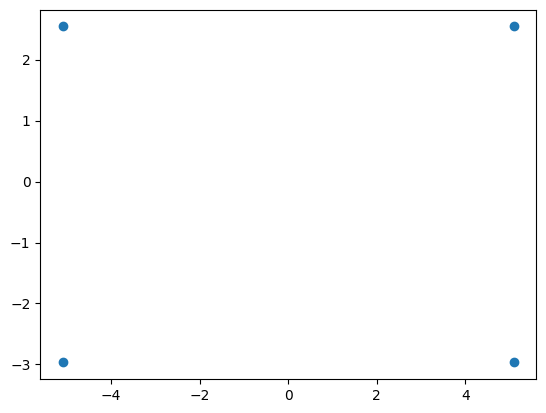

In [181]:
plt.scatter(ns.stim_space['filt_x'],ns.stim_space['filt_y'])

In [67]:
beep = ns.pyramid.project_stimulus(a[0])

project_stimulus:   0%|          | 0/11845 [00:00<?, ?it/s]

project_stimulus: 100%|██████████| 11845/11845 [00:14<00:00, 828.36it/s]


 ...]

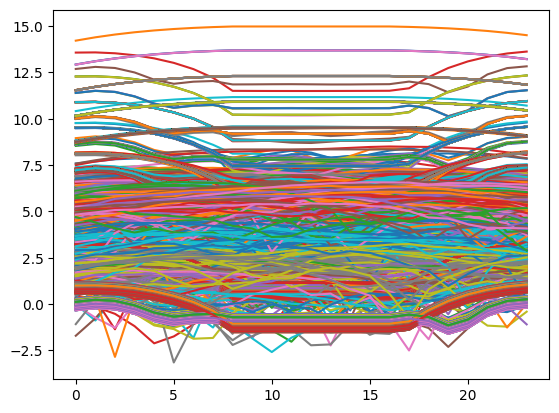

In [71]:
plt.plot(beep)

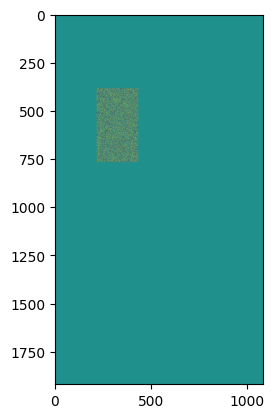

In [59]:
plt.imshow(a[0][-1,:,:],vmin=0, vmax=100)

In [40]:
a[0][10,:,:]

array([[-0.00662583,  0.48665791, -1.01641931, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.34955563, -1.88541673,  0.0444665 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.59276723, -0.67449282,  0.11619102, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], shape=(1920, 1080))

In [130]:
import numpy as np
from sklearn.decomposition import PCA

# Suppose data is a numpy array of shape (n_instances, n_features)
# If yours is (n_features, n_instances), just transpose it:
# data = data.T

# Initialize PCA: choose number of components (e.g. 2) or fraction of variance
pca = PCA(n_components=10)    
# Fit & transform the data
X_reduced = pca.fit_transform(primal_coef.T)  # Transpose to shape (n_instances, n_features)

print("Explained variance ratios:", pca.explained_variance_ratio_)
print("Projected shape:", X_reduced.shape)

Explained variance ratios: [0.20329568 0.07599757 0.04712491 0.02784415 0.02576136 0.01910744
 0.01593169 0.01518215 0.0133578  0.01280965]
Projected shape: (336275, 10)


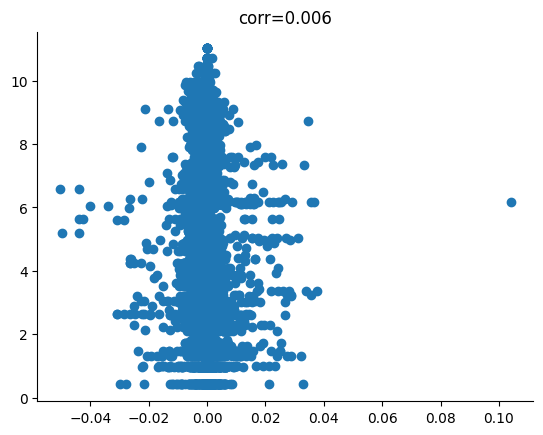

In [ ]:
from dpu_mini.plot_functions import *
r2_mask = r2_flat>0
dag_scatter(
    np.array(ecc)[r2_mask],
    np.array(ecc)[r2_mask],
    do_corr=True
    
)
# plt.gca().set_xlim(-1e-3, 1e-4)

In [192]:
pdir = ns._pref_dir(primal_coef)

(8, 336275)


In [197]:
pdir_max = [ns.stim_tfsf['dir'][pdir[:,i].argmax()] for i in range(pdir.shape[-1])]

In [198]:
pdir_max

[180,
 135,
 135,
 90,
 0,
 0,
 45,
 0,
 45,
 270,
 45,
 270,
 0,
 0,
 45,
 135,
 225,
 225,
 270,
 225,
 45,
 135,
 0,
 90,
 180,
 90,
 225,
 0,
 135,
 180,
 90,
 0,
 45,
 270,
 225,
 0,
 180,
 45,
 180,
 135,
 225,
 0,
 45,
 0,
 270,
 0,
 45,
 135,
 45,
 45,
 90,
 180,
 225,
 0,
 0,
 45,
 0,
 135,
 45,
 0,
 90,
 225,
 135,
 45,
 225,
 0,
 225,
 45,
 225,
 45,
 225,
 225,
 0,
 45,
 45,
 135,
 0,
 135,
 225,
 45,
 45,
 225,
 225,
 45,
 90,
 135,
 0,
 135,
 225,
 45,
 180,
 225,
 45,
 90,
 270,
 270,
 225,
 135,
 225,
 45,
 45,
 90,
 135,
 0,
 90,
 225,
 45,
 45,
 180,
 90,
 0,
 135,
 270,
 45,
 270,
 45,
 0,
 45,
 45,
 180,
 180,
 270,
 135,
 45,
 225,
 225,
 0,
 0,
 135,
 90,
 270,
 0,
 225,
 0,
 225,
 135,
 45,
 45,
 225,
 270,
 45,
 45,
 270,
 225,
 45,
 45,
 45,
 135,
 225,
 0,
 45,
 0,
 135,
 45,
 225,
 0,
 90,
 225,
 225,
 0,
 0,
 225,
 135,
 0,
 0,
 0,
 45,
 0,
 0,
 135,
 0,
 0,
 135,
 225,
 270,
 135,
 0,
 45,
 45,
 225,
 225,
 270,
 225,
 180,
 0,
 225,
 45,
 0,
 225,
 0,
 0,


In [ ]:
wm = ns.filter_weighted_mean(primal_coef,)

In [172]:
wmax = ns.filter_max(weights=primal_coef)

volume shape: (81, 95, 101)
Caching mapper...
Caching mapper...


/tank/marcus/miniconda3/envs/aot_003/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


Unable to init server: Could not connect: Connection refused
Background RRGGBBAA: ffffff00
Area 0:0:1914.89:1024 exported to 1915 x 1024 pixels (96 dpi)
Unable to init server: Could not connect: Connection refused
Background RRGGBBAA: ffffff00
Area 0:0:1914.89:1024 exported to 1915 x 1024 pixels (96 dpi)


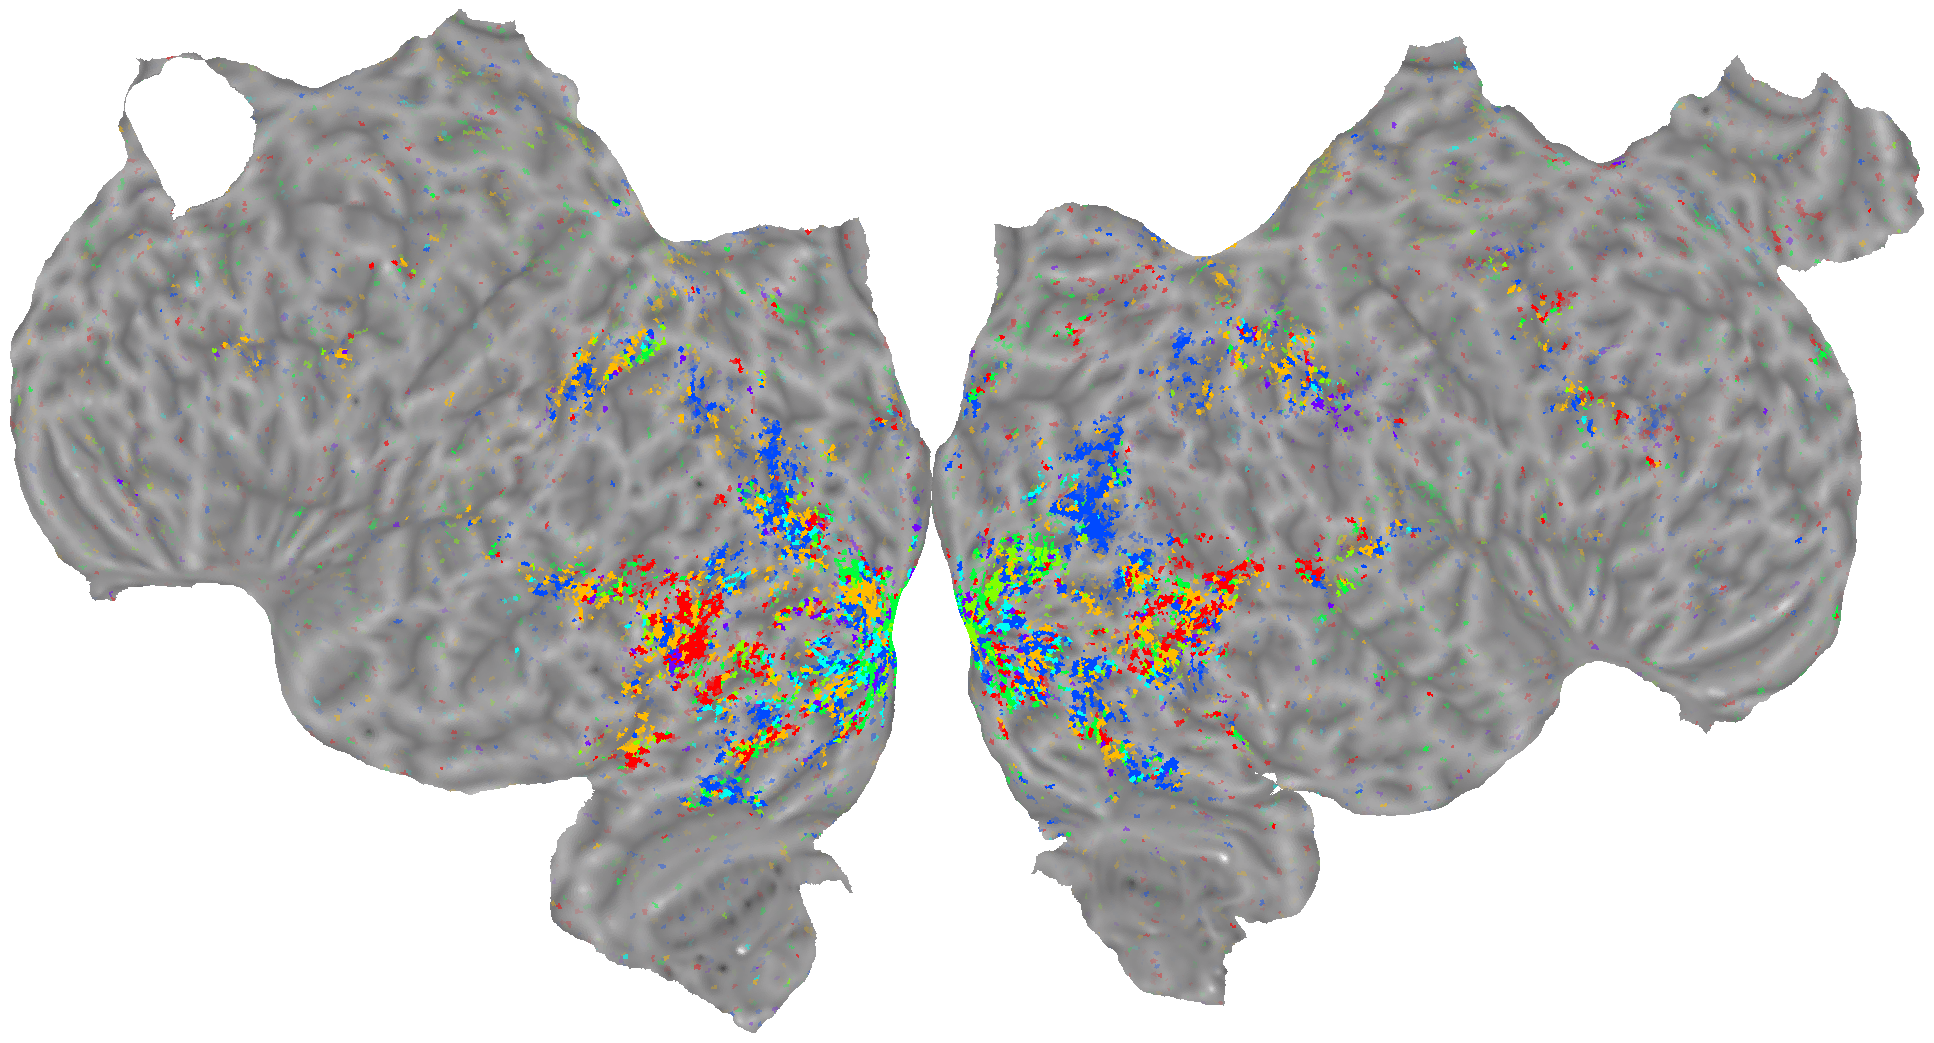

In [199]:
# Reshape the eccentricities into a volume
p = 'pol'
vol = reshape_from_flatten_masked_to_wholebrain(
    pdir_max, #
    # wm['ecc'].to_numpy(), 
    sub=sub)
cx_sub = f'sub-{sub:03d}'
print("volume shape:", vol.shape)

# Transpose the volume to match the expected shape (106, 95, 84)
vol = np.transpose(vol, (2, 1, 0))
cx_vol = cortex.Volume(vol, cx_sub, xfmname='AOT1pt7mm',vmin=0.1, vmax=20, cmap="magma")

mapper = cortex.get_mapper(cx_sub, "AOT1pt7mm", type="nearest", recache=True)
p_map = mapper(cx_vol)

volume_R2 = cortex.Volume(R2_data, cx_sub, "AOT1pt7mm", recache=True)
mapper_R2 = cortex.get_mapper(cx_sub, "AOT1pt7mm", type="nearest", recache=True)
R2_map = mapper_R2(volume_R2)
cmap_kwargs = {
    "cmap": "hsv",
    "vmin": 0,
    "vmax": 360,
}
# Create merged map with R2 as opacity
merged_map = Vertex2D_fix(
    p_map.data,
    R2_map.data,
    cx_sub,

    vmin2=0,
    vmax2=0.01,  # R2 threshold for opacity
    **cmap_kwargs
)
# from dag_prf_utils.plot_functions import *


# Set colormap for surface map
# p_map.cmap = "hsv"

# Display the merged map
_ = cortex.quickshow(
    merged_map,
    with_curvature=False,
    with_colorbar=False,
    with_labels=True,
    with_sulci=True,
    with_legend=False,
    # cmap="hsv",
    colorbar_label=p,
)

# Add figure (a) to plt.gcf()



# from dag_prf_utils. import *
# dag_plot

In [196]:
pdir.shape

(8, 336275)

(array([1.28810e+04, 7.36700e+04, 1.26362e+05, 7.85760e+04, 3.61170e+04,
        1.63860e+04, 6.59900e+03, 1.92600e+03, 3.71000e+02, 2.60000e+01]),
 array([0.01936523, 0.10655743, 0.19374964, 0.28094181, 0.36813402,
        0.45532623, 0.54251844, 0.62971067, 0.71690285, 0.80409503,
        0.89128727]),
 <BarContainer object of 10 artists>)

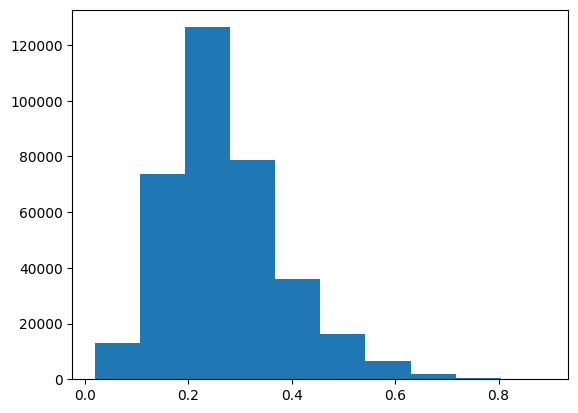

In [19]:
plt.hist(dir_s)

In [11]:
from dpu_mini.mesh_maker import GenMeshMaker

Could not find path for freeview, is freesurfer accessible from here?
Could not find FS_LICENSE
Uncomment line below and specify path to FS_LICENSE
SUBJECTS_DIR not found in os.environ
Adding empty string...


In [12]:
gm = GenMeshMaker(
    sub=cx_sub, 
    # fs_dir=fs_dir
    fs_dir=opj(deriv_dir, 'freesurfer_AOT')
)

Using fs dir = /tank/shared/2024/visual/AOT/derivatives/freesurfer_AOT
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...
Adding offset to mesh...


In [75]:
gm.total_n_vx

308926

In [ ]:
from dpu_mini.fs_tools import dag_load_roi
c_bool = dag_load_roi(cx_sub, 'V1_exvivo.thresh', fs_dir=gm.fs_dir)
submesh_bool = dag_mesh_morph(
    mesh_info=gm.mesh_info['inflated']['lh'], 
    vx_bool=, 
    morph=morph)
gm.make_flat_map(
    centre_bool=,
    morph=-1, 
    method='igl',
    hemi_project='sphere'
)
# gm.flat_mpl(roi_list='V2_')

Missing 2 vx
If you want to be more inclusive try again with morph>0


RuntimeError: Failed to compute harmonic map

In [ ]:
# Create cortex volumes for eccentricities and R2
volume = cortex.Volume(eccentricities_volume, sub, "AOT1pt7mm", recache=True)
mapper = cortex.get_mapper(sub, "AOT1pt7mm", type="nearest", recache=True)
native_surface_map = mapper(volume)

volume_R2 = cortex.Volume(R2_data, sub, "AOT1pt7mm", recache=True)
mapper_R2 = cortex.get_mapper(sub, "AOT1pt7mm", type="nearest", recache=True)
native_surface_map_R2 = mapper_R2(volume_R2)

In [ ]:
filter_info.pyramid.show_filter(3)
plt.show()

In [ ]:
filter_info.pyramid.show_filter(100)
plt.show()

In [ ]:
# Load some 
import os 
opj = os.path.join
subject = "sub-003"
cx_sub = f"aot-{subject}"

deriv_dir = '/tank/shared/2024/visual/AOT/derivatives/'
param_path_dir = opj(deriv_dir, "prf", subject)
fs_dir = opj(deriv_dir, "freesurfer")
os.environ["SUBJECTS_DIR"] = str(fs_dir)
# if not os.path.exists(os.path.join(cortex.database.default_filestore, cx_sub)):
#     cortex.freesurfer.import_subj(freesurfer_subject=subject,
#                                     pycortex_subject=cx_sub,
#                                     freesurfer_subject_dir=fs_dir)

In [ ]:
prf_list = os.listdir(opj(param_path_dir, 'prf_fits', 'params'))
from dpu_mini.utils import *
import nibabel as nib
import cortex
bold_ref = dag_find_file_in_folder(
    ['r2', 'cv', 'gauss'], 
    opj(param_path_dir, 'prf_fits', 'params'),
)
def get_prf_par(filt):
    nii = dag_find_file_in_folder(
        filt, 
        opj(param_path_dir, 'prf_fits', 'params'),
    )
    return nib.load(nii).get_fdata()
vol = get_prf_par(['r2','gauss', 'cv'])
rsq_data = cortex.Volume(vol.transpose(2,1,0), subject='sub-003', 
                         xfmname='epi_1.7mm',
                           vmin=0.1, vmax=0.7, cmap="magma")
sub='sub-003'
volume_R2 = cortex.Volume(vol.transpose(2,1,0), sub, "epi_1.7mm", recache=True)
mapper_R2 = cortex.get_mapper(sub, "epi_1.7mm", type="nearest", recache=True)
# native_surface_map_R2 = mapper_R2(volume_R2)
native_surface_map_R2 = mapper_R2(volume_R2)
# gm.flat_mpl(
#     data=native_surface_map_R2.data,
# )
cortex.quickshow(native_surface_map_R2)

In [ ]:
sub='sub-003'
volume_R2 = cortex.Volume(vol.transpose(2,1,0), sub, "epi_1.7mm", recache=True)
mapper_R2 = cortex.get_mapper(sub, "epi_1.7mm", type="nearest", recache=True)
# native_surface_map_R2 = mapper_R2(volume_R2)
native_surface_map_R2 = mapper_R2(volume_R2)
# gm.flat_mpl(
#     data=native_surface_map_R2.data,
# )
cortex.quickshow(native_surface_map_R2)

In [ ]:
gm.total_n_vx

In [ ]:
# from cortex import quickshow as quickshow
quickshow(rsq_data,)

In [ ]:
cortex.db.get_surf('sub-003', 'flat')

In [ ]:
cortex.vertex_to_voxel('sub-003')

In [ ]:
from dpu_mini.mesh_maker import GenMeshMaker
from dpu_mini.fs_tools import *

gm = GenMeshMaker(subject, fs_dir)
centre_bool = dag_load_roi(subject, 'V1', fs_dir=fs_dir)

gm.make_flat_map(centre_bool=centre_bool,morph=20, method='igl')
gm.flat_mpl(roi_list=['V1', 'V2'])

In [ ]:
from dag_prf_utils.pycortex import *

In [ ]:
import numpy as np
import cortex
custom_affine = np.identity(4)
# custom_affine[1,3] -= 8
# transform = cortex.xfm.Transform(custom_affine, bold_ref)
xfmname = "aot_prep"
# transform.save(cx_sub, xfmname, 'magnet')

In [ ]:
rsq_data = cortex.Volume(gauss_rsq_data.transpose(2,1,0), subject=cx_sub, xfmname='aot_prep', vmin=0.1, vmax=0.7, cmap="magma")
polar_vcx = cortex.Volume(gauss_polar_data.transpose(2,1,0), subject=cx_sub, xfmname='aot_prep', vmin=-np.pi, vmax=np.pi, cmap="Retinotopy_HSV_2x_alpha")
ecc_data = cortex.Volume(gauss_ecc_data.transpose(2,1,0), subject=cx_sub, xfmname='aot_prep', vmin=0, vmax=8, cmap="magma")
x_data = cortex.Volume(gauss_x_data.transpose(2,1,0), subject=cx_sub, xfmname='aot_prep', vmin=-4, vmax=4, cmap="coolwarm")
y_data = cortex.Volume(gauss_y_data.transpose(2,1,0), subject=cx_sub, xfmname='aot_prep', vmin=-4, vmax=4, cmap="coolwarm")
prf_ampl_data = cortex.Volume(gauss_prf_ampl_data.transpose(2,1,0), subject=cx_sub, xfmname='aot_prep', vmin=0, vmax=10, cmap="magma")
prf_size_data = cortex.Volume(gauss_prf_size_data.transpose(2,1,0), subject=cx_sub, xfmname='aot_prep', vmin=0, vmax=6, cmap="magma")

cortex.webgl.show({"rsq": rsq_data, "polar": polar_vcx, "ecc": ecc_data, "x": x_data, "y": y_data, "prf_ampl": prf_ampl_data, "prf_size": prf_size_data,})

In [ ]:
path_bold_ref = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_r2.nii.gz")
param_path_norm_r2 = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_r2.nii.gz")
param_path_norm_ecc = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_ecc.nii.gz")
param_path_norm_polar = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_polar.nii.gz")
param_path_norm_x = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_x.nii.gz")
param_path_norm_y = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_y.nii.gz")
param_path_norm_prf_ampl = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_prf_ampl.nii.gz")
param_path_norm_neur_bsl = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_neur_bsl.nii.gz")
param_path_norm_surr_ampl = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_surr_ampl.nii.gz")
param_path_norm_surr_bsl = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_surr_bsl.nii.gz")
param_path_norm_prf_size = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_prf_size.nii.gz")
param_path_norm_surr_size = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-norm_stage-iter_space-epi_1.7mm_desc-prf_params_surr_size.nii.gz")

param_path_gauss_r2 = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-gauss_stage-iter_space-epi_1.7mm_desc-prf_params_r2.nii.gz")

param_path_gauss_ecc = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-gauss_stage-iter_space-epi_1.7mm_desc-prf_params_ecc.nii.gz")
param_path_gauss_polar = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-gauss_stage-iter_space-epi_1.7mm_desc-prf_params_polar.nii.gz")

param_path_gauss_x = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-gauss_stage-iter_space-epi_1.7mm_desc-prf_params_x.nii.gz")
param_path_gauss_y = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-gauss_stage-iter_space-epi_1.7mm_desc-prf_params_y.nii.gz")
param_path_gauss_prf_ampl = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-gauss_stage-iter_space-epi_1.7mm_desc-prf_params_prf_ampl.nii.gz")
param_path_gauss_prf_size = opj(param_path_dir, f"{subject}_ses-pRF_task-pRF_rec-nordicstc_run-{run}_model-gauss_stage-iter_space-epi_1.7mm_desc-prf_params_prf_size.nii.gz")

In [ ]:
import nibabel as nib
bold_ref = nib.load(path_bold_ref)

gauss_rsq_data = nib.load(param_path_gauss_r2).get_fdata()
gauss_ecc_data = nib.load(param_path_gauss_ecc).get_fdata()

def load_gauss_param_image(param_path, rsq_data=gauss_rsq_data, rsq_threshold=0.1, ecc_data=gauss_ecc_data, ecc_threshold=100):
    param_data = nib.load(param_path).get_fdata()
    param_data[rsq_data<rsq_threshold] = np.nan
    param_data[ecc_data>ecc_threshold] = np.nan
    return param_data

gauss_ecc_data = load_gauss_param_image(param_path_gauss_ecc)
gauss_polar_data = load_gauss_param_image(param_path_gauss_polar)
gauss_x_data = load_gauss_param_image(param_path_gauss_x)
gauss_y_data = load_gauss_param_image(param_path_gauss_y)
gauss_prf_ampl_data = load_gauss_param_image(param_path_gauss_prf_ampl)
gauss_prf_size_data = load_gauss_param_image(param_path_gauss_prf_size)


norm_rsq_data = nib.load(param_path_norm_r2).get_fdata()
norm_ecc_data = nib.load(param_path_norm_ecc).get_fdata()

def load_norm_param_image(param_path, rsq_data=norm_rsq_data, rsq_threshold=0.1, ecc_data=norm_ecc_data, ecc_threshold=100):
    param_data = nib.load(param_path).get_fdata()
    param_data[rsq_data<rsq_threshold] = np.nan
    param_data[ecc_data>ecc_threshold] = np.nan
    return param_data

# rsq_data = load_norm_param_image(param_path_r2)
norm_ecc_data = load_norm_param_image(param_path_norm_ecc)
norm_polar_data = load_norm_param_image(param_path_norm_polar)
norm_x_data = load_norm_param_image(param_path_norm_x)
norm_y_data = load_norm_param_image(param_path_norm_y)
norm_prf_ampl_data = load_norm_param_image(param_path_norm_prf_ampl)
norm_neur_bsl_data = load_norm_param_image(param_path_norm_neur_bsl)
norm_surr_ampl_data = load_norm_param_image(param_path_norm_surr_ampl)
norm_surr_bsl_data = load_norm_param_image(param_path_norm_surr_bsl)
norm_prf_size_data = load_norm_param_image(param_path_norm_prf_size)
norm_surr_size_data = load_norm_param_image(param_path_norm_surr_size)


In [ ]:
import cortex
from dag_prf_utils.pycortex import *


In [ ]:
get_ctx_path